# Initial functions

Import libraries

In [139]:
#Import library
%matplotlib qt
import numpy as np
import staticCreepModule as creeplib
import matplotlib.pyplot as plt
import pandas as pd
import datetime 

#Configurations of how to process data
setOfSpecimens=0
deriveLVDT=True
timeInspection=False

Get the path of the test results

In [140]:
# Get path of the folder containing the test results
from tkinter.filedialog import askopenfilename, askdirectory
from tkinter import Tk
import os
root = Tk().withdraw()
path = askdirectory()
Tk().destroy()

Construct specimen and experimental objects

In [141]:
'''
GENERAL INFO ABOUT THE TEST
----------------------------------------------------------------------------
SPECIMEN    BATCH   SYSTEM          LVDTS       BASE_LENGTH(MM)     APPLIED_STRESS(MPA)
----------------------------------------------------------------------------
SP1                 inegi        5,4,7       65.04667        8.47083
SP2                 inegi        9,8,6       57.63667        9.56737
SP3                 inegi        10,11,3       56.47667        9.66956
SP4                 inegi        1,2,0       56.50667           8.59628
----------------------------------------------------------------------------
'''
#Instantiate test specimens data
SP1=creeplib.testSpecimen("SP1",'inegi',[6,5,8],65.04667, 8.47083, ["SP1-LVDT_2A","SP1-LVDT_1A","SP1-LVDT_4A"], [(1,0,0),(1,0.40,0.40),(1,0.70,0.70)],['-','--','-.'])
SP2=creeplib.testSpecimen("SP2",'inegi',[10,9,7],57.63667, 9.56737,  ["SP2-LVDT_5A","SP2-LVDT_5","SP2-LVDT_3A"],[(0,0,0),(0.2,0.20,0.20),(0.70,0.70,0.70)],['-','--','-.'])
SP3=creeplib.testSpecimen("SP3",'inegi',[11,12,4],56.47667, 9.66956, ["SP3-LVDT_7","SP3-LVDT_9","SP3-LVDT_10"], [(0,1,1),(0.2,1,1),(0.4,1,1)],['-','--','-.'])
SP4=creeplib.testSpecimen("SP4",'inegi',[2,3,1],56.50667, 8.59628, ["SP4-LVDT_0","SP4-LVDT_1","SP4-HS_25"], [(1,1,1),(0.95,1,1),(0.90,1,1)],['-','--','-.'])
#Instasntiate load cell data
loadCellInterface=creeplib.loadCell("Interface-LC", 'inegi', 13, (1,0,0), '--')
#Instantiate loading switch data
loadingSwitch=creeplib.loadingSwitch()

#Option 1:
experiment = creeplib.experiment([SP1,SP2,SP3,SP4],[loadCellInterface],loadingSwitch)

### Release correction

In [142]:
#Deal with sudden releases occured in the LVDTs, when they get unstucked
#For line number, subtract 25 from the line number in Excel - this means subtracting the entire header of the file, counting from the first line of acquired data
#Remeber that if, for a given specimen, more than 1 LVDT line needs correction per file, than they all should be stated in the same method call
#This framework is probably not prepared if more than 1 correction per file is needed. If such case happens, we need to reimplement some things

SP2.addReleaseCorrection('2023-07-17-12-42-S26.csv',["SP2-LVDT_5"],[547],[-0.16647228])
SP2.addReleaseCorrection('2023-07-24-20-02-S31.csv',["SP2-LVDT_5"],[233],[0.17222328])

SP2.addReleaseCorrection('2023-08-02-08-47-S36.csv',["SP2-LVDT_5"],[1391],[-0.16036344])
SP2.addReleaseCorrection('2023-10-02-18-05-S54.csv',["SP2-LVDT_5"],[1],[0.07261596])
SP2.addReleaseCorrection('2023-10-08-17-02-S59.csv',["SP2-LVDT_5"],[1],[-0.07261596])
SP4.addReleaseCorrection('2023-10-02-18-05-S54.csv',["SP4-HS_25"],[1],[0.0595])

SP4.addReleaseCorrection('2023-07-13-08-51-S23.csv',["SP4-HS_25"],[50],[0.0198])

### Read data

In this test, there occurred a power shortage between "2024-04-18 10:25" and "2024-04-21 00:00", which made the temperature fall and affected the creep tendency momentarily. This is not ideal but I think the results will not go to waste and we can use them simply skipping this period of test so the curves don't see a tooth in the middle of their trend

In [143]:
experiment.readCreep_Batch(path, 'fileName')

# Set beginning of test data

In [144]:
SP1.setStartOfTest(datetime.datetime(year=2023, month=6, day=29, hour=11,minute=28, second=25, microsecond=953700))
SP2.setStartOfTest(datetime.datetime(year=2023, month=6, day=29, hour=11,minute=31, second=53, microsecond=520810))
SP3.setStartOfTest(datetime.datetime(year=2023, month=6, day=29, hour=11,minute=34, second=35, microsecond=191000))
SP4.setStartOfTest(datetime.datetime(year=2023, month=6, day=29, hour=11,minute=37, second=17, microsecond=773000))

SP1.setStartOfCreep(datetime.datetime(year=2023, month=6, day=29, hour=11,minute=29, second=45, microsecond=953700))
SP2.setStartOfCreep(datetime.datetime(year=2023, month=6, day=29, hour=11,minute=33, second=13, microsecond=520810))
SP3.setStartOfCreep(datetime.datetime(year=2023, month=6, day=29, hour=11,minute=35, second=55, microsecond=191000))
SP4.setStartOfCreep(datetime.datetime(year=2023, month=6, day=29, hour=11,minute=38, second=37, microsecond=773000))

# Investigate raw results

Analyse individual results

In [111]:
#Piece of code used to see specimen and loading switch data
specimenAnalysed=SP3_altered

fig,ax = plt.subplots()

for idx, series in enumerate(specimenAnalysed.displacementData):
    if idx==0:
        referenceSeries=np.array(specimenAnalysed.displacementData[series])
        mean=np.zeros(len(specimenAnalysed.displacementData[series]))
    #deltaTime=SP4.timeData-SP4.timeData[0]
    #deltaTime=[time-SP2.timeData[0] for time in SP2.timeData]
    #shiftedTimeData=[(value-datetime.timedelta(seconds=specimenAnalysed.creepStartTime)-specimenAnalysed.timeData[0]).total_seconds() for value in specimenAnalysed.timeData]
    mean=mean+np.abs(specimenAnalysed.displacementData[series])
    #ax.plot(specimenAnalysed.plotTime, np.array(specimenAnalysed.displacementData[series])/(specimenAnalysed.baseLength), label=series)
    #ax.plot(specimenAnalysed.plotTime, (1e6)*np.array(specimenAnalysed.displacementData[series])/(specimenAnalysed.baseLength*specimenAnalysed.appliedStress), label=series)
    ax.plot(specimenAnalysed.plotTime, np.array(specimenAnalysed.displacementData[series])/referenceSeries, label=series)

#ax.plot(specimenAnalysed.plotTime, mean/(3*specimenAnalysed.baseLength), "--", label=series[:3]) 
#ax.plot(specimenAnalysed.plotTime, (1e6)*mean/(3*specimenAnalysed.baseLength*specimenAnalysed.appliedStress), "--", label=series[:3]) 
#ax.plot(specimenAnalysed.plotTime, mean/(3), "--", label=series[:3]) 

#plt.xscale("log")
plt.legend()
plt.show()

C:\Users\Renan\AppData\Local\Temp\ipykernel_19484\2392127203.py:16: RuntimeWarning: invalid value encountered in divide
  ax.plot(specimenAnalysed.plotTime, np.array(specimenAnalysed.displacementData[series])/referenceSeries, label=series)
C:\Users\Renan\AppData\Local\Temp\ipykernel_19484\2392127203.py:16: RuntimeWarning: divide by zero encountered in divide
  ax.plot(specimenAnalysed.plotTime, np.array(specimenAnalysed.displacementData[series])/referenceSeries, label=series)


In [146]:
#Piece of code used to see specimen and loading switch data
specimenAnalysed=SP1

fig,ax = plt.subplots()

for idx, series in enumerate(specimenAnalysed.displacementData):
    if idx==0:
        mean=np.zeros(len(specimenAnalysed.displacementData[series]))
    #deltaTime=SP4.timeData-SP4.timeData[0]
    #deltaTime=[time-SP2.timeData[0] for time in SP2.timeData]
    #shiftedTimeData=[(value-datetime.timedelta(seconds=specimenAnalysed.creepStartTime)-specimenAnalysed.timeData[0]).total_seconds() for value in specimenAnalysed.timeData]
    mean=mean+np.abs(specimenAnalysed.displacementData[series])/specimenAnalysed.baseLength
    #ax.plot(specimenAnalysed.plotTime, (1e6)*np.array(specimenAnalysed.displacementData[series])/(specimenAnalysed.baseLength*specimenAnalysed.appliedStress), label=series)
    ax.plot(specimenAnalysed.plotTime, np.array(specimenAnalysed.displacementData[series])/specimenAnalysed.baseLength, label=series)

#ax.plot(specimenAnalysed.plotTime, (1e6)*mean/(3*specimenAnalysed.baseLength*specimenAnalysed.appliedStress), "--", label=series[:3]) 
ax.plot(specimenAnalysed.plotTime, mean/(3), "--", label=series[:3]) 

#plt.xscale("log")
plt.legend()
plt.show()

Analyse average results

In [153]:
#Piece of code used to see specimen and loading switch data
specimenList=[SP1_altered, SP2, SP3_altered, SP4]

fig,ax = plt.subplots()
shiftY=0
shiftX=80
for id, specimen in enumerate(specimenList):
    specimenAnalysed=specimen


    for idx, series in enumerate(specimenAnalysed.displacementData):
        if idx==0:
            mean=np.zeros(len(specimenAnalysed.displacementData[series]))
        #deltaTime=SP4.timeData-SP4.timeData[0]
        #deltaTime=[time-SP2.timeData[0] for time in SP2.timeData]
        #shiftedTimeData=[(value-datetime.timedelta(seconds=specimenAnalysed.creepStartTime)-specimenAnalysed.timeData[0]).total_seconds() for value in specimenAnalysed.timeData]
        mean=mean+np.abs(specimenAnalysed.displacementData[series])
        #ax.plot(specimenAnalysed.plotTime, (1e6)*np.array(specimenAnalysed.displacementData[series])/(specimenAnalysed.baseLength*specimenAnalysed.appliedStress), label=series)

    if id==2:
        shiftY=20-58-10.2+7.18-33+37-9.18-7.18
    if id==0:
        shiftY=-58+5.91
    else:
        shiftY=-58
    #shiftY=0
    ax.plot((np.array(specimenAnalysed.plotTime)-shiftX)/(60*60*24), shiftY+(1e6)*mean/(3*specimenAnalysed.baseLength*specimenAnalysed.appliedStress), "--", label=series[:3]) 

plt.title("SP3 and SP1_1 adjusted on the mechanics at early age")
plt.xscale("log")
plt.legend()
plt.show()

### Manual corrections

These manual corrections have to be done because intereferences with LVDTs occurred which cannot be solved with the trustness analysis. For example, one of the LVDTs did not move at all, which prevents from builing the trust factor based on a trust region in which the LVDTs worked fine

In [147]:
import copy
SP3_altered = copy.deepcopy(SP3)
SP3_altered.displacementData['SP3-LVDT_9']=[np.mean([0.694*(value1),1.171*value2]) for value1, value2 in zip(SP3_altered.displacementData['SP3-LVDT_7'],SP3_altered.displacementData['SP3-LVDT_10'])]
#SP3_altered.displacementData['SP3-LVDT_9']=[(3*(SP3_altered.baseLength)*SP3_altered.appliedStress/Eass)-value1-value2 for value1, value2 in zip(SP3_altered.displacementData['SP3-LVDT_7'],SP3_altered.displacementData['SP3-LVDT_10'])]

In [148]:
import copy
Eass=20e3
SP1_altered = copy.deepcopy(SP1)
SP1_altered.displacementData['SP3-LVDT_9']=[np.mean([0.162*(value1),0.157*value2]) for value1, value2 in zip(SP1_altered.displacementData['SP1-LVDT_1A'],SP1_altered.displacementData['SP1-LVDT_2A'])]

In [151]:
import copy
Eass=20e3
SP1_altered_2 = copy.deepcopy(SP1)
SP1_altered_2.displacementData['SP3-LVDT_9']=[0.2*(value1+value2) for value1, value2 in zip(SP1_altered.displacementData['SP1-LVDT_1A'],SP1_altered.displacementData['SP1-LVDT_2A'])]

In [137]:
SP3.displacementData['SP3-LVDT_9']=[0.57*(value1+value2) for value1, value2 in zip(SP3.displacementData['SP3-LVDT_7'],SP3.displacementData['SP3-LVDT_10'])]
SP1.displacementData['SP1-LVDT_4A']=[0.2*(value1+value2) for value1, value2 in zip(SP1.displacementData['SP1-LVDT_1A'],SP1.displacementData['SP1-LVDT_2A'])]
#SP4.displacementData['SP4-HS_25']=[1.3*(value1+value2) for value1, value2 in zip(SP4.displacementData['SP4-LVDT_0'],SP4.displacementData['SP4-LVDT_1'])]

# Trustness correction

This correction is an idea to use only the LVDT lines which we have trust on their measurements. This may allow to savage data from specimens with bad LVDTs that would, otherwise, be thrown in the garbage. Maybe later spcimens can be pondered in the average results by their associated uncertainty (which would definetly allow for penalizing those specimens with fewer LVDTs).

The code below performs the thrustness analysis and store the results in a dataframe that gets exported to a xlsx in the end

## Average of datapoints in trust interval

This is the main method to be used. It computes trust proportions between each measured point in the trusted region, and in the end averages all the proportions to have a single value for correction. It is more recommended because in some way it may consider random variations occurrying in the trust region.

In [7]:
#THIS VERSION TRIES TO USE AN AVERAGILIZED QUANTITY OF THE TRUST SERIES
trustAnalysis=[[specimen.specimenID] for specimen in experiment.testSpecimensList]
trustSeries=[[] for specimen in experiment.testSpecimensList]

#Here below we need to associate, for each specimen, which LVDTs are thrustworthy (TRUE) and which are not (FALSE)
#The order of specimens and LVDT lines follow the same as those in the definiton of experiment object and specimen objects
untrustedLinesIndex=[   [True, True,  True],
                        [True,  True,  True],
                        [True,  True,   True],
                        [True,  True,   True]]

trustInterval = [[800000],[600000],[600000],[3000000,6000000]]

for j, specimenAnalysed in enumerate(experiment.testSpecimensList):
    if False not in untrustedLinesIndex[j]:
        #Then this line dont need correction, skip it
        for line in range(0,3+3+3+1+3+1+1):
            trustAnalysis[j].append(None)
        trustAnalysis[j].append([None])
    else:
        keywordTrustfulLines=[]
        trustSeries=[]
        #Select the interval of the data in which we trust in the creep data
        for series in specimenAnalysed.displacementData:
            keywordTrustfulLines.append(series)
            #deltaTime=SP4.timeData-SP4.timeData[0]
            #deltaTime=[time-SP2.timeData[0] for time in SP2.timeData]
            shiftedTimeData=[(value-datetime.timedelta(seconds=specimenAnalysed.creepStartTime)-specimenAnalysed.timeData[0]).total_seconds() for value in specimenAnalysed.timeData]
            if len(trustInterval[j])==1:
                firstIndex=next(i for i,x in enumerate(shiftedTimeData) if x >= 0)
                lastIndex=next(i for i,x in enumerate(shiftedTimeData) if x > trustInterval[j][0])
            elif len(trustInterval[j])==2:
                firstIndex=next(i for i,x in enumerate(shiftedTimeData) if x >= trustInterval[j][0])
                lastIndex=next(i for i,x in enumerate(shiftedTimeData) if x > trustInterval[j][1])
            else:
                print("trustInterval variable must be a list of list, with each list either having single element defining the ending time in the trust interval, or two elements defining the start and ending times.")
            trustSeries.append(specimenAnalysed.displacementData[series][firstIndex:lastIndex:10])

        #Compute the trust quantities for each point within the trust region
        sumTrustSeries=[]
        propSumTrustSeries=[]
        trustSumFactorSeries=[]
        untrustSumFactorSeries=[]
        for index, point in enumerate(trustSeries[0]):
            propTrustSeries=[]
            currentWorkingPoints=[trustSeries[0][index],trustSeries[1][index],trustSeries[2][index]]
            #Complete the initialDisp vector
            sumTrustSeries.append(np.sum(currentWorkingPoints))
            for el in currentWorkingPoints:
                propTrustSeries.append(el/sumTrustSeries[index])
            propSumTrustSeries.append(np.sum(propTrustSeries))
            trustSumFactor=0
            untrustSumFactor=[]
            for lineIndex in range(0,3):
                if untrustedLinesIndex[j][lineIndex] is True:
                    trustSumFactor=trustSumFactor+propTrustSeries[lineIndex]
                else:
                    untrustSumFactor.append(propTrustSeries[lineIndex])
            trustSumFactorSeries.append(trustSumFactor)
            untrustSumFactorSeries.append(untrustSumFactor)
        
        #Compute the average of the trust quantities
        for line in range(0,3):
            trustAnalysis[j].append(untrustedLinesIndex[j][line])
        for line in range(0,3):
            trustAnalysis[j].append(specimenAnalysed.channelsName[line])
        for line in range(0,3):
            trustAnalysis[j].append(np.mean(trustSeries[line]))
        trustAnalysis[j].append(np.mean(sumTrustSeries))
        for line in range(0,3):
            trustAnalysis[j].append(np.mean(propTrustSeries[line]))
        trustAnalysis[j].append(np.mean(propSumTrustSeries))
        trustAnalysis[
            j].append(np.mean(trustSumFactorSeries))
        tempSeries=[[] for dummy2 in untrustSumFactorSeries[0]]
        for k, dummy1 in enumerate(untrustSumFactorSeries[0]):
            for n, point in enumerate(untrustSumFactorSeries):
                tempSeries[k].append(point[k])
        trustAnalysis[j].append([np.mean(untrustSeries) for untrustSeries in tempSeries])

df = pd.DataFrame(trustAnalysis, columns=[  'Specimen','L1-trust?', 'L2-trust?', 'L3-trust?',
                                            'L1 id', 'L2 id', 'L3 id',
                                            'L1-displac.', 'L2-displac.', 'L3-displac.', 'Total-displac.', 
                                            'Prop1', 'Prop2', 'Prop3', 'TotalProp','TrustSumFactor','UntrustFactors'])

df.to_excel(r'C:\Users\Renan\OneDrive\Renan\Engenharia Civil\Ensaios\230628-CREEP-29_03_AGE-AC_0_4\03-CODE\updated_algorithm-20240516\trustAnalysis_2.xlsx') 

In [ ]:
print("oi")

In [ ]:
plt.plot(untrustSumFactorSeries)

## Generalized average

This is another method, that first averages all the points in the trust interval to calcualte the trust proportions

In [ ]:
#This just takes the mean of the interval
trustAnalysis=[[specimen.specimenID] for specimen in experiment.testSpecimensList]

#Here below we need to associate, for each specimen, which LVDTs are thrustworthy (TRUE) and which are not (FALSE)
#The order of specimens and LVDT lines follow the same as those in the definiton of experiment object and specimen objects
untrustedLinesIndex=[[False,   True,   True],
                      [True,    False,  True],
                      [True,    False,  False],
                      [True,    True,   False]]

trustInterval = [30000,30000,16000,30000]

for j, specimenAnalysed in enumerate(experiment.testSpecimensList):
    keywordTrustfulLines=[]

    for series in specimenAnalysed.displacementData:
        keywordTrustfulLines.append(series)
        #deltaTime=SP4.timeData-SP4.timeData[0]
        #deltaTime=[time-SP2.timeData[0] for time in SP2.timeData]
        shiftedTimeData=[(value-datetime.timedelta(seconds=specimenAnalysed.creepStartTime)-specimenAnalysed.timeData[0]).total_seconds() for value in specimenAnalysed.timeData]
        firstIndex=next(i for i,x in enumerate(shiftedTimeData) if x >= 0)
        lastIndex=next(i for i,x in enumerate(shiftedTimeData) if x >= trustInterval[j])
        trustAnalysis[j].append(np.mean(specimenAnalysed.displacementData[series][firstIndex:lastIndex]))

    #Complete the initialDisp vector
    trustAnalysis[j].append(np.sum(trustAnalysis[j][1:]))
    for el in trustAnalysis[j][1:4]:
        trustAnalysis[j].append(el/trustAnalysis[j][4])
    trustAnalysis[j].append(np.sum(trustAnalysis[j][5:8]))

    #Compute sum factors for thrust lines and unthrusted lines
    trustSumFactor=0
    untrustSumFactor=[]
    for lineIndex in range(0,3):
        if untrustedLinesIndex[j][lineIndex] is True:
            #Then the current line is thrustful
            trustSumFactor=trustSumFactor+trustAnalysis[j][5+lineIndex]
        else:
            untrustSumFactor.append(trustAnalysis[j][5+lineIndex])
    trustAnalysis[j].append(trustSumFactor)
    trustAnalysis[j].append(untrustSumFactor)

df = pd.DataFrame(trustAnalysis, columns=['Specimen', 'L1-displac.', 'L2-displac.', 'L3-displac.', 'Total-displac.', 
                                           'Prop1', 'Prop2', 'Prop3', 'TotalProp','TrustSumFactor','UntrustFactors'])

df.to_excel(r'C:\Users\Renan\OneDrive\Renan\Engenharia Civil\Ensaios\240326-CREEP-40C\03-CODE\trustAnalysis.xlsx') 

## Empirical corrections

These are the old corrections, much more empirical

In [ ]:
#SP2
specimenAnalysed=SP2
trustSumIndex=0
trustLineIndex=[1,2]

trustSumFactor=[0.710697149,0.83089024,0.250535332,0.787567894]
untrustFactor=[[0.289302851],[0.16910976],[0.2751606,0.474304069],[0.212432106]]

#Get data series
keywordTrustfulLines=[]
for series in specimenAnalysed.displacementData:
    keywordTrustfulLines.append(series)

if trustSumIndex == 2:
    #Then we are with SP4, which has only one trust line
    sumOfLines=[(value1)/trustSumFactor[trustSumIndex] for value1 in specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[0]]]]
else:
    #All the other specimens have 2 trust lines
    sumOfLines=[(value1+value2)/trustSumFactor[trustSumIndex] for value1, value2 in zip(specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[0]]],specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[1]]])]

j=0
for i in range(3):
    if i in trustLineIndex:
        pass
    else:
        specimenAnalysed.displacementData[keywordTrustfulLines[i]]=[value*untrustFactor[trustSumIndex][j] for value in sumOfLines]
        j=j+1

In [ ]:
#SP3
specimenAnalysed=SP3
trustSumIndex=1
trustLineIndex=[0,2]

trustSumFactor=[0.710697149,0.83089024,0.250535332,0.787567894]
untrustFactor=[[0.289302851],[0.16910976],[0.2751606,0.474304069],[0.212432106]]

#Get data series
keywordTrustfulLines=[]
for series in specimenAnalysed.displacementData:
    keywordTrustfulLines.append(series)

if trustSumIndex == 2:
    #Then we are with SP4, which has only one trust line
    sumOfLines=[(value1)/trustSumFactor[trustSumIndex] for value1 in specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[0]]]]
else:
    #All the other specimens have 2 trust lines
    sumOfLines=[(value1+value2)/trustSumFactor[trustSumIndex] for value1, value2 in zip(specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[0]]],specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[1]]])]

j=0
for i in range(3):
    if i in trustLineIndex:
        pass
    else:
        specimenAnalysed.displacementData[keywordTrustfulLines[i]]=[value*untrustFactor[trustSumIndex][j] for value in sumOfLines]
        j=j+1

In [ ]:
#SP4
specimenAnalysed=SP4
trustSumIndex=2
trustLineIndex=[0]

trustSumFactor=[0.710697149,0.83089024,0.250535332,0.787567894]
untrustFactor=[[0.289302851],[0.16910976],[0.2751606,0.474304069],[0.212432106]]

#Get data series
keywordTrustfulLines=[]
for series in specimenAnalysed.displacementData:
    keywordTrustfulLines.append(series)

if trustSumIndex == 2:
    #Then we are with SP4, which has only one trust line
    sumOfLines=[(value1)/trustSumFactor[trustSumIndex] for value1 in specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[0]]]]
else:
    #All the other specimens have 2 trust lines
    sumOfLines=[(value1+value2)/trustSumFactor[trustSumIndex] for value1, value2 in zip(specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[0]]],specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[1]]])]

j=0
for i in range(3):
    if i in trustLineIndex:
        pass
    else:
        specimenAnalysed.displacementData[keywordTrustfulLines[i]]=[value*untrustFactor[trustSumIndex][j] for value in sumOfLines]
        j=j+1

In [ ]:
#SP5
specimenAnalysed=SP5
trustSumIndex=3
trustLineIndex=[0,1]

trustSumFactor=[0.710697149,0.83089024,0.250535332,0.787567894]
untrustFactor=[[0.289302851],[0.16910976],[0.2751606,0.474304069],[0.212432106]]

#Get data series
keywordTrustfulLines=[]
for series in specimenAnalysed.displacementData:
    keywordTrustfulLines.append(series)

if trustSumIndex == 2:
    #Then we are with SP4, which has only one trust line
    sumOfLines=[(value1)/trustSumFactor[trustSumIndex] for value1 in specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[0]]]]
else:
    #All the other specimens have 2 trust lines
    sumOfLines=[(value1+value2)/trustSumFactor[trustSumIndex] for value1, value2 in zip(specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[0]]],specimenAnalysed.displacementData[keywordTrustfulLines[trustLineIndex[1]]])]

j=0
for i in range(3):
    if i in trustLineIndex:
        pass
    else:
        specimenAnalysed.displacementData[keywordTrustfulLines[i]]=[value*untrustFactor[trustSumIndex][j] for value in sumOfLines]
        j=j+1

# Apply corrections based on the trust analysis

In [24]:
for j, specimenAnalysed in enumerate(experiment.testSpecimensList):
    #Get data series
    keywordTrustfulLines=[]
    keywordUntrustfulLines=[]
    trustfulLines=[]
    sumOfTrustfulLines=[0 for el in list(specimenAnalysed.displacementData.values())[0]]

    for i, series in enumerate(specimenAnalysed.displacementData):
        if untrustedLinesIndex[j][i] is True:
            #keywordTrustfulLines.append(series)
            #trustfulLines.append(specimenAnalysed.displacementData[series])
            for k, measurement in enumerate(specimenAnalysed.displacementData[series]):
                sumOfTrustfulLines[k]=sumOfTrustfulLines[k]+measurement/df.loc[j,'TrustSumFactor']
        else:
            keywordUntrustfulLines.append(series)

    #Now correct the unstrustful lines:
    for i, series in enumerate(keywordUntrustfulLines):
        specimenAnalysed.displacementData[series]=[value*df.loc[j,'UntrustFactors'][i] for value in sumOfTrustfulLines]
    

# Conclusions

This trust analysis had the following conclusions:

1. SP2 does not need any processing. Its LVDT lines indeed behave undesirably and most likely rigid body movements in the aluminum rings occurred, but they appeare to not affect the mean of the measurements and could have been compensate among the different LVDT lines (e.g., while one or two sides descendended, the other rised in such a proportion that when the average was taken the average creep compliance was mantained). This can be observed, for example, between around time 0.2e7 and 0.5e7 on LVDT_5A and LVDT_3A. From 0.2e7, while 3A presented a lowered trend, LVDT5A increased its rate of increase atipically. From 0.5e7, these two trends where interrupted, LVDT5A appeared to return to a steady rate, while LVDT3A appearead to return to its previous rate approximately. This whole time, LVDT5 was much less sensitive to what happened in the other lines.

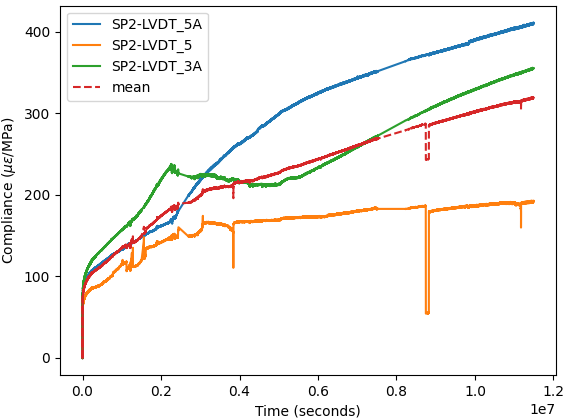

2. SP4 is affected by issues beyond repair from 6e6 seconds onwards. From this time onwards, HS_25 and LVDT_1 present a sharp decrease which seems to be partly compensated by LVDT_0, but upon closer inspection there is no clear indication on what is the mechanism underlining the behaviour of their measurements. Any attempts for corrections would suffer from lack of objectiveness. Many were attempted like eliminating HS_25 line and working with just the trends from the other two lines, but no success was achieved.

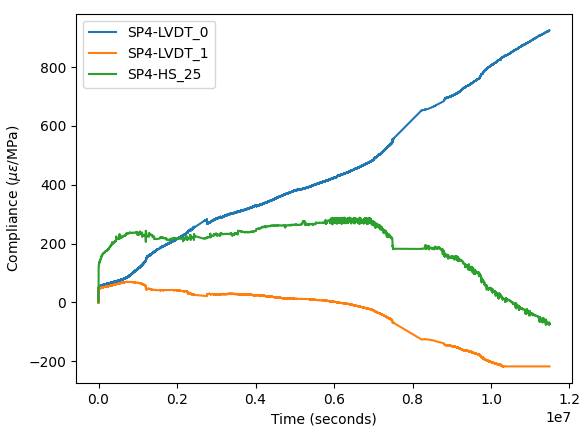

3. SP3 has one line that did not move at all. It was verified that the LVDT piston got stucked and never moved during testing. It is strange because in the beginning this really makes the compliance start at a lower level, as if the specimen was many times stiffer than the rest of the specimens. However, at higher ages, the mean compliance equalizes the rest of the specimens, both in terms of rate and value. This can only be explained if the immobile LVDT, if working, would actually measure something in the first part of the test but would progressively decrease its contribution until reaching zero. We can also compute some correction, as we did in SP1 to consider the imovable line there so it matched the initial elastic modulus, but if we do so, the compliance gets a little larger. However, I think it is the most appropriate methodology, to perform the correction based on the mechanics of the distribution of the force in both SP3 and SP1, and try to use the result as is.

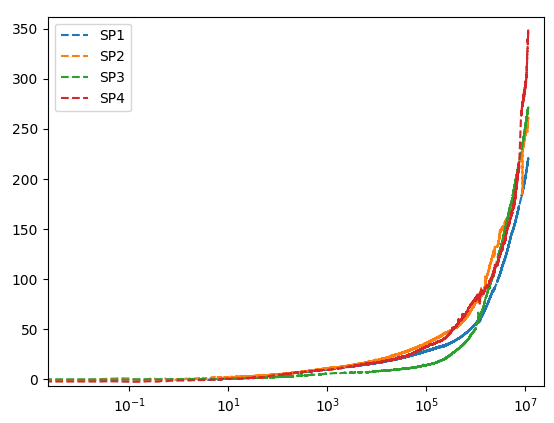

4. It suffers the same issue of SP1 and the same approach to solve it will be taken.